# Read Dataset

In [1]:
import warnings
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")       # Set themes for plots
drive.mount('/content/gdrive')        # Connect to Google Drive
warnings.filterwarnings("ignore")     # Ignore Warnings

Mounted at /content/gdrive


In [ ]:
# Reading data
train = pd.read_csv('/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/train.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/test.csv')

# Feature Engineering
- Autoencoder for dimensionality reduction. I am compressing the 200 features into 20 features and adding these 20 features as engineered features to existing data. I will be passing the entire train set into encoder-decoder architecture, after autoencoder part gets trained, I will be removing the decoding part and just keep the encoder and bottleneck part. This is because I need the compressed version of data. 

### Encoder-Deoder Model

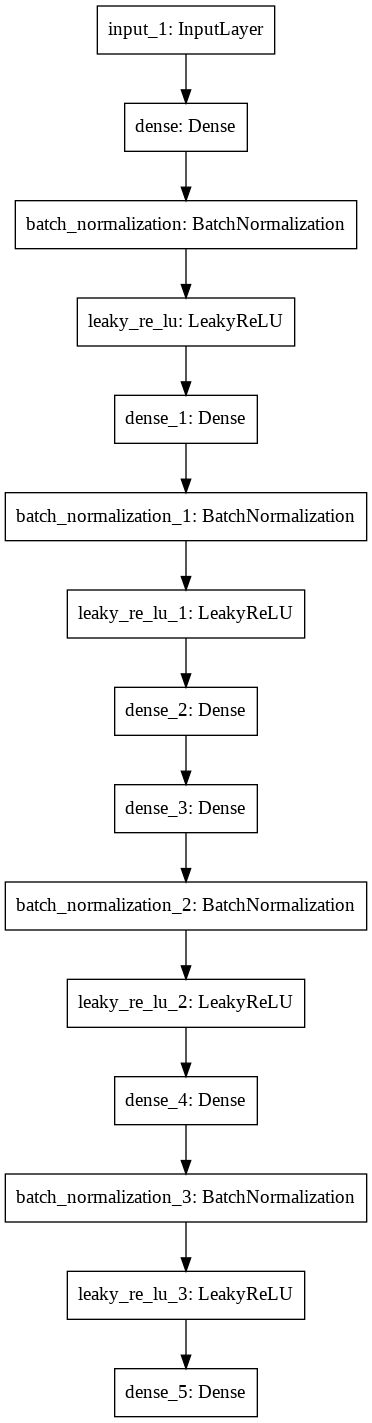

In [ ]:
# Reference: https://www.youtube.com/watch?v=La-ZxnyIxco
import tensorflow as tf

# Autoencoder model preparation
n_inputs = 200
n_bottleneck = 20

# Input shape
input_shape = tf.keras.Input(shape=(n_inputs,))

# Encoder level 1
encoder = tf.keras.layers.Dense(n_inputs*2)(input_shape)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.LeakyReLU()(encoder)

# Encoder level 2
encoder = tf.keras.layers.Dense(n_inputs)(encoder)
encoder = tf.keras.layers.BatchNormalization()(encoder)
encoder = tf.keras.layers.LeakyReLU()(encoder)

# Bottleneck
bottleneck = tf.keras.layers.Dense(n_bottleneck)(encoder)

# Decoder level 1
decoder = tf.keras.layers.Dense(n_inputs)(bottleneck)
decoder = tf.keras.layers.BatchNormalization()(decoder)
decoder = tf.keras.layers.LeakyReLU()(decoder)

# Decoder level 2
decoder = tf.keras.layers.Dense(n_inputs*2)(decoder)
decoder = tf.keras.layers.BatchNormalization()(decoder)
decoder = tf.keras.layers.LeakyReLU()(decoder)

# Output layer
output = tf.keras.layers.Dense(n_inputs, activation='linear')(decoder)

# Model
model = tf.keras.Model(inputs=input_shape, outputs=output)

# Compiling the model
model.compile(optimizer='adam', loss='mse')

# Model flowchart
tf.keras.utils.plot_model(model=model)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Scale data
scale = MinMaxScaler()
X = scale.fit_transform(train.iloc[:, 2:])  # Fit transform train data
X_ = scale.transform(test.iloc[:, 1:])      # Transform test data
y = train.iloc[:, 1]                        # Target variable

In [ ]:
# Fitting the model
fit = model.fit(X, y, epochs=50, batch_size=512, verbose=2)

Epoch 1/50
391/391 - 11s - loss: 0.0816
Epoch 2/50
391/391 - 10s - loss: 0.0677
Epoch 3/50
391/391 - 10s - loss: 0.0663
Epoch 4/50
391/391 - 10s - loss: 0.0650
Epoch 5/50
391/391 - 10s - loss: 0.0631
Epoch 6/50
391/391 - 10s - loss: 0.0608
Epoch 7/50
391/391 - 10s - loss: 0.0587
Epoch 8/50
391/391 - 10s - loss: 0.0566
Epoch 9/50
391/391 - 10s - loss: 0.0544
Epoch 10/50
391/391 - 10s - loss: 0.0524
Epoch 11/50
391/391 - 10s - loss: 0.0507
Epoch 12/50
391/391 - 10s - loss: 0.0493
Epoch 13/50
391/391 - 10s - loss: 0.0477
Epoch 14/50
391/391 - 10s - loss: 0.0463
Epoch 15/50
391/391 - 10s - loss: 0.0445
Epoch 16/50
391/391 - 10s - loss: 0.0431
Epoch 17/50
391/391 - 10s - loss: 0.0415
Epoch 18/50
391/391 - 10s - loss: 0.0399
Epoch 19/50
391/391 - 10s - loss: 0.0387
Epoch 20/50
391/391 - 10s - loss: 0.0373
Epoch 21/50
391/391 - 10s - loss: 0.0361
Epoch 22/50
391/391 - 10s - loss: 0.0349
Epoch 23/50
391/391 - 10s - loss: 0.0343
Epoch 24/50
391/391 - 10s - loss: 0.0333
Epoch 25/50
391/391 - 10s

### Adding New Features

In [ ]:
autoencoder_model = tf.keras.Model(inputs=input_shape, outputs=bottleneck)
train_encoded_features = autoencoder_model.predict(X)
test_encoded_features = autoencoder_model.predict(X_)

print(f'Dtype of encoded features: {type(train_encoded_features)}')
print('Converting to dataframe:')
train_df_encoded = pd.DataFrame(train_encoded_features)
test_df_encoded = pd.DataFrame(test_encoded_features)
print(f'Shape of train encoded data: {train_df_encoded.shape}')
print(f'Shape of test encoded data: {test_df_encoded.shape}')

Dtype of encoded features: <class 'numpy.ndarray'>
Converting to dataframe:
Shape of train encoded data: (200000, 20)
Shape of test encoded data: (200000, 20)


In [ ]:
train_df_encoded['target'] = y
train_df_encoded.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,target
0,-0.108237,1.170683,1.356106,1.014645,-3.035961,2.074746,0.333649,-2.701436,-2.807689,1.856411,-3.802175,0.991260,-1.326812,-1.409759,-4.021441,-0.733682,0.280624,3.082047,0.097452,0.622364,0
1,0.020474,-3.323930,1.750568,1.385047,-2.912157,0.060618,-1.985704,-0.140011,-2.277792,1.927119,-2.861892,2.483546,-4.280710,2.598017,-3.107758,0.616635,-0.795664,1.103561,1.733681,4.307333,0
2,-0.039258,2.196214,1.547078,1.841604,-2.108332,0.810043,0.658812,-1.289997,-2.346098,0.333488,-1.564337,0.655044,-1.206448,-1.700017,-2.003543,-1.214971,-0.019423,1.366641,-0.219804,0.650444,0


In [ ]:
test_df_encoded.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.450380,-3.457882,1.368482,1.357085,-2.290530,-1.313754,-1.410742,0.056571,-0.930345,1.346795,-1.127237,2.521199,-3.035751,2.201909,-1.565611,1.328786,-1.058705,1.712495,2.958799,3.994922
1,0.115497,-4.277657,0.632791,-4.117366,0.361312,-2.425124,0.099787,-1.324432,5.305585,4.489563,-1.205564,3.025155,1.466975,2.598691,-0.629906,4.809687,0.071613,2.392011,2.542660,0.173834
2,-0.127234,-3.096170,1.454013,-3.610392,-1.816144,-1.239492,-0.115690,-1.871833,2.807404,3.305468,-1.816472,3.250333,0.251528,2.482716,-2.202161,3.178613,-0.644287,4.237484,2.188210,-0.127784


In [ ]:
# Checking for null values
print(train_df_encoded.isnull().values.any())
print(test_df_encoded.isnull().values.any())

False
False


### Merging Engineered Features to Original Train and Test Data

In [ ]:
final_train = train.iloc[:, 2:].merge(train_df_encoded, how='inner', left_index=True, right_index=True)
final_test = test.iloc[:, 1:].merge(test_df_encoded, how='inner', left_index=True, right_index=True)

print(f'Shape of final train data: {final_train.shape}')
print(f'Shape of final test data: {final_test.shape}')

Shape of final train data: (200000, 221)
Shape of final test data: (200000, 220)


# Train Test Split and Balancing the Dataset

In [2]:
# Train test split
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

final_train = pd.read_csv('/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/final_train.csv')
final_test = pd.read_csv('/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/final_test.csv')

X = final_train.iloc[:, :-1]
y = final_train.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(f'Shape of X_train data: {X_train.shape}')
print(f'Shape of X_test data: {X_test.shape}')
print(f'Shape of y_train data: {y_train.shape}')
print(f'Shape of y_test data: {y_test.shape}')
print('-'*65)
print(f'Value counts of train target labels: {Counter(y_train)}')
print('-'*65)
print(f'Value counts of test target labels: {Counter(y_test)}')

Shape of X_train data: (140000, 220)
Shape of X_test data: (60000, 220)
Shape of y_train data: (140000,)
Shape of y_test data: (60000,)
-----------------------------------------------------------------
Value counts of train target labels: Counter({0: 126005, 1: 13995})
-----------------------------------------------------------------
Value counts of test target labels: Counter({0: 53897, 1: 6103})


In [3]:
# Upsampling the minority class in train data to balance the data
# Reference: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')      # Define oversampling strategy
X_over, y_over = oversample.fit_resample(X_train, y_train)        # Fit and apply the transform
print(f'Value counts of train target labels: {Counter(y_over)}')

Value counts of train target labels: Counter({0: 126005, 1: 126005})


# Machine Learning Models

## Random Model



In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

'''
- For every Xi's we generate estimated Yi randomly to be either 0 or 1. This is also called dumb model. 
- Given a random model I will compute the log loss, which will be considered as the *worst case scenario* model.
-Log loss can lie between [0, inf]. My aim is to build a ML model which performs better than random model i.e., log loss should be less than the random model.
'''

y_pred = np.random.choice([0, 1], size=y_test.shape[0])
tn, fp, fn, tp = confusion_matrix(y_test.to_numpy(), y_pred).ravel()
specificity = tn / (tn+fp)
Sensitivity = tp / (tp+fn)

random_performance = pd.DataFrame({'Random Model': [round(log_loss(y_test.to_numpy(), y_pred), 2), round(accuracy_score(y_test.to_numpy(), y_pred), 2), round(precision_score(y_test.to_numpy(), y_pred), 2),
                                                    round(recall_score(y_test.to_numpy(), y_pred), 2), round(f1_score(y_test.to_numpy(), y_pred), 2), round(specificity, 2), round(Sensitivity, 2)]}, 
                                  index = ['Log Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Sensitivity'])
random_performance

,Random Model
Log Loss,17.34
Accuracy,0.50
Precision,0.10
Recall,0.50
F1 Score,0.17
Specificity,0.50
Sensitivity,0.50


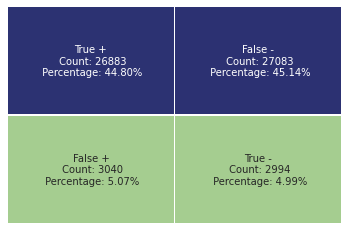

In [ ]:
# Function for confusion matrix
def get_confusion_matrix(cm):
    group_names = ['True +','False -','False +','True -']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n Count: {v2}\n Percentage: {v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return sns.heatmap(cm, annot=labels, fmt='', cmap='crest', linewidths=.2, yticklabels=False, xticklabels=False, cbar=False);
cm = confusion_matrix(y_test.to_numpy(), y_pred)
get_confusion_matrix(cm);

## Stochastic Gradient Descent Classifier

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, log_loss

In [ ]:
# Grid search cross validation
loss  = ['log', 'hinge']
penalty  = ['l1', 'l2']
alpha  = [0.0001, 0.001, 0.01]


params = {'loss':loss, 'penalty':penalty, 'alpha':alpha}

sgd = SGDClassifier()
classifier_sgd = GridSearchCV(sgd, params, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=2)
classifier_sgd.fit(X_over, y_over)

best_score_sgd = classifier_sgd.best_score_
best_params_sgd = classifier_sgd.best_params_
best_estimator_sgd = classifier_sgd.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 26.1min finished


In [ ]:
print(f'Best Score: {best_score_sgd}')
print(f'Best Params: {best_params_sgd}')
print(f'Best Estimator: {best_estimator_sgd}')

Best Score: 0.9317694792530422
Best Params: {'alpha': 0.01, 'loss': 'hinge', 'penalty': 'l2'}
Best Estimator: SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [ ]:
sgd = SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
sgd.fit(X_over, y_over)
y_pred_sgd = sgd.predict(X_test.values) # Probability esimates available for los=log

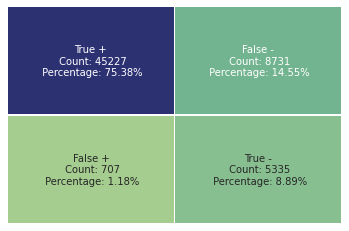

In [ ]:
cm = confusion_matrix(y_test, y_pred_sgd)
get_confusion_matrix(cm);

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_sgd).ravel()
specificity = tn / (tn+fp)
Sensitivity = tp / (tp+fn)

SGD_performance = pd.DataFrame({'SGD Model': [round(log_loss(y_test, y_pred_sgd), 2), round(accuracy_score(y_test, y_pred_sgd), 2), round(precision_score(y_test, y_pred_sgd), 2),
                                                    round(recall_score(y_test, y_pred_sgd), 2), round(f1_score(y_test, y_pred_sgd), 2), round(specificity, 2), round(Sensitivity, 2)]}, 
                                  index = ['Log Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Sensitivity'])
SGD_performance

,SGD Model
Log Loss,5.43
Accuracy,0.84
Precision,0.38
Recall,0.88
F1 Score,0.53
Specificity,0.84
Sensitivity,0.88


## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Grid search cross validation
criterion  = ['gini', 'entropy']
max_depth = [50, 100, 150, 200]


params = {'criterion':criterion, 'max_depth':max_depth}

dt = DecisionTreeClassifier()
classifier_dt = GridSearchCV(dt, params, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=2)
classifier_dt.fit(X_over, y_over)

best_score_dt = classifier_dt.best_score_
best_params_dt = classifier_dt.best_params_
best_estimator_dt = classifier_dt.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 16.4min finished


In [ ]:
print(f'Best Score: {best_score_dt}')
print(f'Best Params: {best_params_dt}')
print(f'Best Estimator: {best_estimator_dt}')

Best Score: 0.9825875000548905
Best Params: {'criterion': 'entropy', 'max_depth': 150}
Best Estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=150, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [ ]:
dt = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=150, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
dt.fit(X_over, y_over)
y_pred_dt = dt.predict(X_test.values)

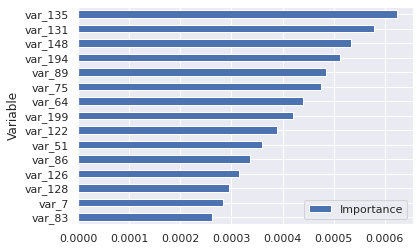

In [ ]:
importance_df = pd.DataFrame({'Variable': X.columns, 'Importance': dt.feature_importances_})
importance_df.sort_values(by='Importance')[:15].plot.barh(x='Variable');

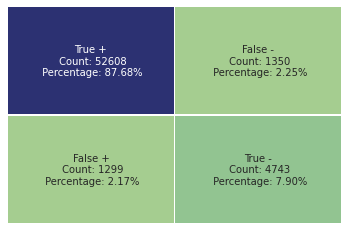

In [ ]:
cm = confusion_matrix(y_test, y_pred_dt)
get_confusion_matrix(cm);

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_dt).ravel()
specificity = tn / (tn+fp)
Sensitivity = tp / (tp+fn)

DT_performance = pd.DataFrame({'DT Model': [round(log_loss(y_test, y_pred_dt), 2), round(accuracy_score(y_test, y_pred_dt), 2), round(precision_score(y_test, y_pred_dt), 2),
                                                    round(recall_score(y_test, y_pred_dt), 2), round(f1_score(y_test, y_pred_dt), 2), round(specificity, 2), round(Sensitivity, 2)]}, 
                                  index = ['Log Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Sensitivity'])
DT_performance

,DT Model
Log Loss,1.52
Accuracy,0.96
Precision,0.78
Recall,0.79
F1 Score,0.78
Specificity,0.97
Sensitivity,0.79


## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Grid search cross validation
criterion  = ['gini', 'entropy']
max_depth = [50, 100, 150, 200]


params = {'criterion':criterion, 'max_depth':max_depth}

rf = RandomForestClassifier()
classifier_rf = GridSearchCV(rf, params, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=2)
classifier_rf.fit(X_over, y_over)

best_score_rf = classifier_rf.best_score_
best_params_rf = classifier_rf.best_params_
best_estimator_rf = classifier_rf.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 54.6min finished


In [ ]:
print(f'Best Score: {best_score_rf}')
print(f'Best Params: {best_params_rf}')
print(f'Best Estimator: {best_estimator_rf}')

Best Score: 0.9999536437473956
Best Params: {'criterion': 'entropy', 'max_depth': 200}
Best Estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=200, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf.fit(X_over, y_over)
y_pred_rf = rf.predict(X_test.values)

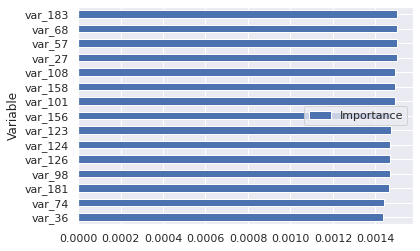

In [ ]:
importance_df = pd.DataFrame({'Variable': X.columns, 'Importance': rf.feature_importances_})
importance_df.sort_values(by='Importance')[:15].plot.barh(x='Variable');

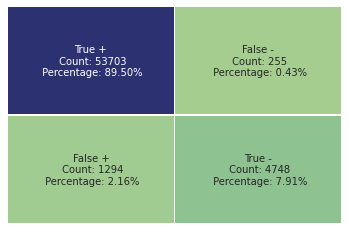

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
get_confusion_matrix(cm);

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
specificity = tn / (tn+fp)
Sensitivity = tp / (tp+fn)

RF_performance = pd.DataFrame({'RF Model': [round(log_loss(y_test, y_pred_rf), 2), round(accuracy_score(y_test, y_pred_rf), 2), round(precision_score(y_test, y_pred_rf), 2),
                                                    round(recall_score(y_test, y_pred_rf), 2), round(f1_score(y_test, y_pred_rf), 2), round(specificity, 2), round(Sensitivity, 2)]}, 
                                  index = ['Log Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Sensitivity'])
RF_performance

,RF Model
Log Loss,0.89
Accuracy,0.97
Precision,0.95
Recall,0.79
F1 Score,0.86
Specificity,1.00
Sensitivity,0.79


## Adaptive Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Grid search cross validation
learning_rate  = [0.001, 0.01, 0.1, 1]
n_estimators = [50, 100, 150, 200]


params = {'n_estimators':n_estimators, 'learning_rate':learning_rate}

ada = AdaBoostClassifier()
classifier_ada = GridSearchCV(ada, params, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=2)
classifier_ada.fit(X_over, y_over)

best_score_ada = classifier_ada.best_score_
best_params_ada = classifier_ada.best_params_
best_estimator_ada = classifier_ada.best_estimator_

In [ ]:
print(f'Best Score: {best_score_ada}')
print(f'Best Params: {best_params_ada}')
print(f'Best Estimator: {best_estimator_ada}')

Best Score: 0.9608193800377632
Best Params: {'learning_rate': 1, 'n_estimators': 200}
Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=200, random_state=None)


In [ ]:
ada = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=200, random_state=None)
ada.fit(X_over, y_over)
y_pred_ada = ada.predict(X_test.values)

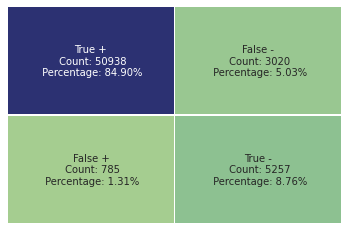

In [ ]:
cm = confusion_matrix(y_test, y_pred_ada)
get_confusion_matrix(cm);

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_ada).ravel()
specificity = tn / (tn+fp)
Sensitivity = tp / (tp+fn)

ADA_performance = pd.DataFrame({'ADABoost Model': [round(log_loss(y_test, y_pred_ada), 2), round(accuracy_score(y_test, y_pred_ada), 2), round(precision_score(y_test, y_pred_ada), 2),
                                                    round(recall_score(y_test, y_pred_ada), 2), round(f1_score(y_test, y_pred_ada), 2), round(specificity, 2), round(Sensitivity, 2)]}, 
                                  index = ['Log Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Sensitivity'])
ADA_performance

,ADABoost Model
Log Loss,2.19
Accuracy,0.94
Precision,0.64
Recall,0.87
F1 Score,0.73
Specificity,0.94
Sensitivity,0.87


## Extreme Gradient Boosting Classifier

In [ ]:
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance, XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, log_loss

print(xgb.__version__)

0.90


In [ ]:
# Grid search cross validation
max_depth = [1, 2, 3, 4, 5, 6]
n_estimators = [50, 100, 150, 200]
learning_rate = [0.001, 0.01, 0.1]


params = {'max_depth': max_depth,'n_estimators': n_estimators, 'learning_rate': learning_rate}

xgb = xgb.XGBClassifier()
classifier_xbg = GridSearchCV(xgb, params, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=2)
classifier_xbg.fit(X_over, y_over)

best_score_xgb = classifier_xbg.best_score_
best_params_xgb = classifier_xbg.best_params_
best_estimator_xgb = classifier_xbg.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 34.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 274.1min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 407.9min finished


In [ ]:
print(f'Best Score: {best_score_xgb}')
print(f'Best Params: {best_params_xgb}')
print(f'Best Estimator: {best_estimator_xgb}')

Best Score: 0.9976051319162981
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}
Best Estimator: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
# Fitting the model
xgb = xgb.XGBClassifier(objective = 'binary:logistic', max_depth=6, n_estimators=200, learning_rate=0.1)
xgb.fit(X_over, y_over)
y_pred_xgb = xgb.predict(X_test.values)
predictions_xgb = [round(value) for value in y_pred_xgb]

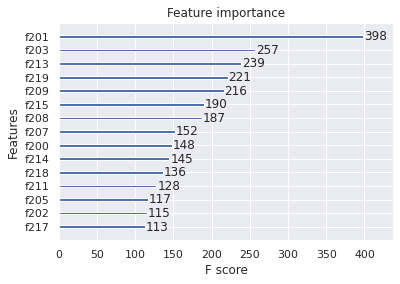

In [ ]:
# Top 10 important features
plot_importance(xgb, title='Feature importance', show_values=True, max_num_features=15);

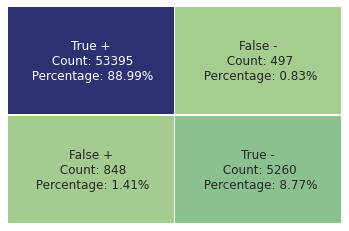

In [ ]:
cm = confusion_matrix(y_test, predictions_xgb)
get_confusion_matrix(cm);

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_xgb).ravel()
specificity = tn / (tn+fp)
Sensitivity = tp / (tp+fn)

XGB_performance = pd.DataFrame({'XGBoost Model': [round(log_loss(y_test, predictions_xgb), 2), round(accuracy_score(y_test, predictions_xgb), 2), round(precision_score(y_test, predictions_xgb), 2),
                                                    round(recall_score(y_test, predictions_xgb), 2), round(f1_score(y_test, predictions_xgb), 2), round(specificity, 2), round(Sensitivity, 2)]}, 
                                  index = ['Log Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Sensitivity'])
XGB_performance

,XGBoost Model
Log Loss,0.79
Accuracy,0.98
Precision,0.91
Recall,0.86
F1 Score,0.88
Specificity,0.99
Sensitivity,0.86


## Light Gradient Boosting

In [4]:
import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance
print(lgb.__version__)

2.2.3


In [ ]:
# Grid search cross validation
learning_rate = [0.05, 0.01, 0.1]
n_estimators = [50, 100, 150, 200]
num_leaves = [i for i in range(10, 100, 10)]

params = {'learning_rate': learning_rate,'n_estimators': n_estimators, 'num_leaves':num_leaves}

lgb = LGBMClassifier()
classifier_lgb= GridSearchCV(lgb, params, cv=3, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=2)
classifier_lgb.fit(X_over, y_over)

best_score_lgb = classifier_lgb.best_score_
best_params_lgb = classifier_lgb.best_params_
best_estimator_lgb = classifier_lgb.best_estimator_

print(f'Best Score: {best_score_lgb}')
print(f'Best Params: {best_params_lgb}')
print(f'Best Estimator: {best_estimator_lgb}')

Best Score: 0.9994646699038295
Best Params: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 90}
Best Estimator: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=90, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [5]:
lgb_classifier = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                                importance_type='split', learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=200, n_jobs=-1, num_leaves=90, objective=None,
                                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000, subsample_freq=0,feature_fraction=0.04, 
                                min_data_in_leaf=12, min_gain_to_split=0.6, num_threads=8)
lgb_classifier.fit(X_over, y_over)
predictions_lgb = lgb_classifier.predict(X_test.values)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.04, importance_type='split',
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=12,
               min_gain_to_split=0.6, min_split_gain=0.0, n_estimators=200,
               n_jobs=-1, num_leaves=90, num_threads=8, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [7]:
filename = 'finalized_model.pkl'
pickle.dump(lgb_classifier, open(filename, 'wb'))

Reference:
I have used self estimated parameters as well as used some parameters from kaggle notebooks.
- https://www.kaggle.com/jesucristo/santander-magic-lgb-0-901#Submission
- https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm
- https://www.kaggle.com/chocozzz/santander-lightgbm-baseline-lb-0-899
- https://www.kaggle.com/jesucristo/santander-magic-lgb-0-901
- https://www.kaggle.com/super13579/pytorch-nn-cyclelr-k-fold-0-897-lightgbm-0-899

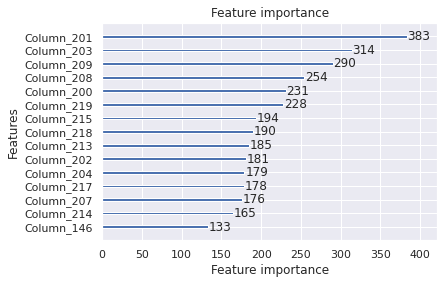

In [ ]:
# Top 15 important features
plot_importance(lgb_classifier, title='Feature importance', max_num_features=15);

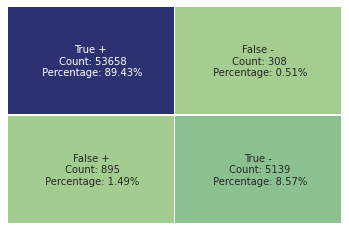

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, predictions_lgb)
get_confusion_matrix(cm);

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions_lgb).ravel()
specificity = tn / (tn+fp)
Sensitivity = tp / (tp+fn)

LGB_performance = pd.DataFrame({'Light GBM Model': [round(log_loss(y_test, predictions_lgb), 2), round(accuracy_score(y_test, predictions_lgb), 2), round(precision_score(y_test, predictions_lgb), 2),
                                                    round(recall_score(y_test, predictions_lgb), 2), round(f1_score(y_test, predictions_lgb), 2), round(specificity, 2), round(Sensitivity, 2)]}, 
                                  index = ['Log Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity', 'Sensitivity'])
LGB_performance

,Light GBM Model
Log Loss,0.69
Accuracy,0.98
Precision,0.94
Recall,0.85
F1 Score,0.90
Specificity,0.99
Sensitivity,0.85


# Summarize Result and Performance <br>


![image.png](https://machinelearningmastery.com/wp-content/uploads/2019/12/How-to-Choose-a-Metric-for-Imbalanced-Classification-latest.png)
### Santander case study is pertaining to transaction made by a customer. This is a critical and intricate matter which should not involve any type of error. Therefore we to give very high importance to false negative and false positive rate here. Our aim should be minimize both of these values. Transacted getting classified as not transacted and not transacted getting classified as transacted will lead to loss for either of the parties. In such delicate issue rather than focusing on metrics which give weightage to true positive and true negative, focus should only be on reducing false negative and false positives. Hence F1 score seems to be most appropriate measure. 
Reference: https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

In [ ]:
temp = random_performance.merge(SGD_performance, left_index=True, right_index=True)
temp = temp.merge(DT_performance, left_index=True, right_index=True)
temp = temp.merge(RF_performance, left_index=True, right_index=True)
temp = temp.merge(XGB_performance, left_index=True, right_index=True)
temp = temp.merge(ADA_performance, left_index=True, right_index=True)
summarized_result = temp.merge(LGB_performance, left_index=True, right_index=True)
summarized_result = pd.read_csv('/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/performance.csv')
summarized_result

,Metrics,Random Model,SGD Model,DT Model,RF Model,ADABoost Model,XGBoost Model,Light GBM Model
0,Log Loss,17.28,5.43,1.52,0.89,2.19,0.79,0.69
1,Accuracy,0.50,0.84,0.96,0.97,0.94,0.98,0.98
2,Precision,0.10,0.38,0.78,0.95,0.64,0.91,0.94
3,Recall,0.51,0.88,0.79,0.79,0.87,0.86,0.86
4,F1 Score,0.17,0.53,0.78,0.86,0.73,0.88,0.90
5,Specificity,0.50,0.84,0.97,1.00,0.94,0.99,0.99
6,Sensitivity,0.51,0.88,0.79,0.79,0.87,0.86,0.86


In [ ]:
def color_positive_green(val):
    if val > 1:
        color = 'red'
    else:
        color = 'green'
    return 'color: %s' % color
  
summarized_result.iloc[:1, 1:].style.applymap(color_positive_green)

,Random Model,SGD Model,DT Model,RF Model,ADABoost Model,XGBoost Model,Light GBM Model
0,17.280000,5.430000,1.520000,0.890000,2.190000,0.790000,0.690000


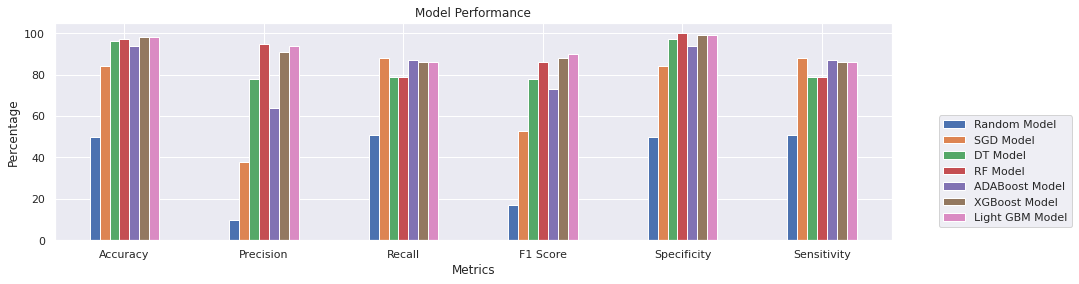

In [ ]:
# Converting scores in percentage terms
metrics = summarized_result.iloc[1:, 1:]*100
metrics.plot.bar(figsize=(15, 4));
plt.xticks(rotation='horizontal');
plt.title('Model Performance');
plt.legend(metrics.columns, bbox_to_anchor = (1.05, 0.6));
plt.xlabel('Metrics');
plt.ylabel('Percentage');
default_x_ticks = range(0,6)
plt.xticks(default_x_ticks, summarized_result['Metrics'][1:]);

# Conclusion

- Both XGBoost and LightGBM have performed well, but basis our performance metrics, LightGBM would be considered having highest F1 score and lowest log loss. Log loss and Recall are the decision making metrics for this problem. Rest all metrics are returning equal scores. 
- False negative was seen lower in case of Light GBM model (0.5%), indiating that not transacted label incorrectly getting classified as transacted. However False positive remains to be almost similar in both the cases (1.4%)
- Time execution was lowest in case of light GBM.
- Common important features are 201, 203, 213, 219, 209, 215, 208, 207, 200, 214, 218 and 217. 12 of 15 features are common in both models.
- Log loss should be as minimum as possible. Considering threshold to be 1, Random forest, XG Boost and Light GBM models have a very low log loss score.
- None of the kaggle notebooks I came across have used auto encoder to come up with extrafeatures. I believe usig autoencoder is a brilliant way to retain infomation in a compressed manner.

# Kaggle Competition Private Scores

In [ ]:
# Predict using Stochastic Gradient Descent Classifier
predicted_y_sgd = sgd.predict_proba(final_test.values)[:, 1]

# Predict using Decision Tree Classifier
predicted_y_dt = dt.predict_proba(final_test.values)[:, 1]

# Predict using Random Forest Classifier
predicted_y_rf = rf.predict_proba(final_test.values)[:, 1]

# Predict using AaBoost Classifier
predicted_y_ada = ada.predict_proba(final_test.values)[:, 1]

# Predict using XGBoost Classifier
predicted_y_xgb = xgb.predict_proba(final_test.values)[:, 1]

# Predict using LightGBM Classifier
predicted_y_lgb = lgb_classifier.predict_proba(final_test.values)[:, 1]

In [ ]:
consolidated_predictions = pd.DataFrame({'SGD': predicted_y_sgd, 'DT': predicted_y_dt, 'RF': predicted_y_rf, 'ADA': predicted_y_ada, 'XGB': predicted_y_xgb, 'LGB': predicted_y_lgb})
consolidated_predictions.to_csv('consolidated.csv', index=False)

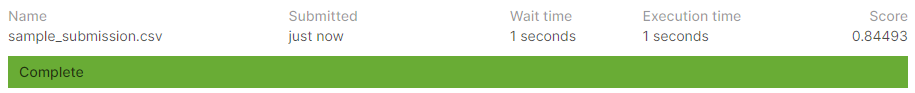

In [ ]:
from IPython import display 
# SGD Score
display.Image("/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/sgd.PNG")

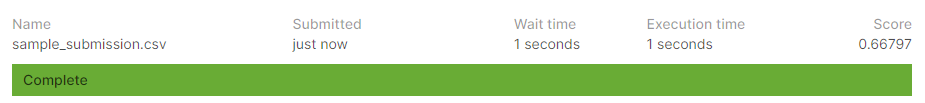

In [ ]:
# Decision Tree
display.Image("/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/dt.PNG")

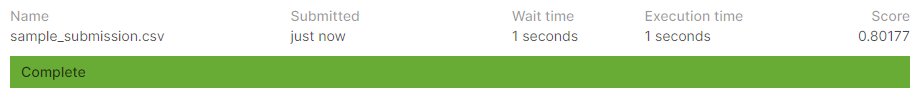

In [ ]:
# Random Forest
display.Image("/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/rf.PNG")

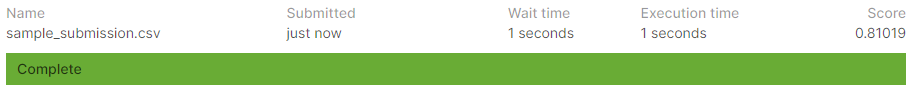

In [ ]:
# Adaboost
display.Image("/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/ada.PNG")

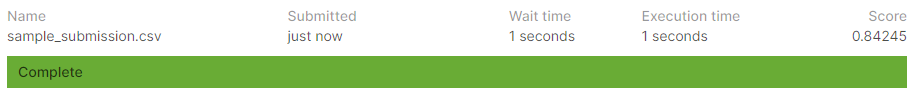

In [ ]:
# XGboost
display.Image("/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/xgb.PNG")

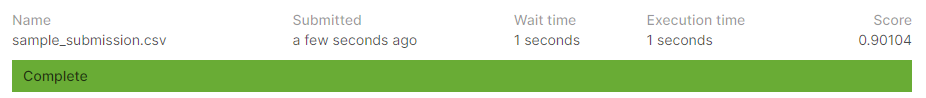

In [ ]:
# LightGBM
display.Image("/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/lgb.PNG")

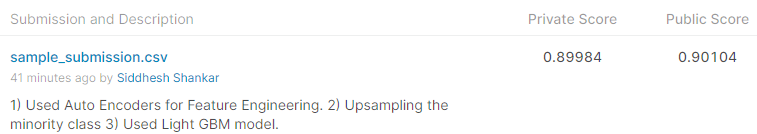

In [ ]:
# Final Score
display.Image("/content/gdrive/MyDrive/Case Studies/Santander Customer Transaction Prediction/FinalScore.PNG")

In [ ]:
kaggle_results = pd.DataFrame({'SGD': [84.4], 'DT': [66.7], 'RF': [80.1], 'ADA': [81], 'XGB': [84.2], 'LGB': [90.1]})
def color_positive_green(val):
    if val > 85:
        color = 'green'
    else:
        color = 'red'
    return 'color: %s' % color
  
kaggle_results.style.applymap(color_positive_green)

,SGD,DT,RF,ADA,XGB,LGB
0,84.400000,66.700000,80.100000,81,84.200000,90.100000


Based on Kaggle test set SGD classifier, XGBoost and Light GBM have has performed well as compared to other classifiers. Out of these 3 we can choose Light GBM model as it has the highest score.

Maximum score in kaggle competition is around 92%. Considering this case study to be on applying ML technique, **90.104%** score using Light GBM is an excellent score with a rank of **374** in the leadership board. 